In [29]:
from sgp4.api import Satrec, jday
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy import integrate
import pandas as pd
import plotly.express as px
import math

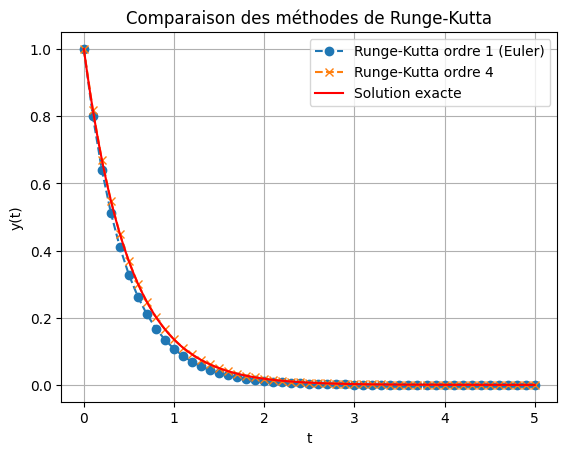

In [30]:
def runge_kutta_order1(f, y0, t0, t_end, h):
    """
    Implémente la méthode de Runge-Kutta d'ordre 1 (Euler explicite).
    """
    t_vals = np.arange(t0, t_end + h, h)
    y_vals = np.zeros(len(t_vals))
    y_vals[0] = y0

    for i in range(1, len(t_vals)):
        t = t_vals[i - 1]
        y = y_vals[i - 1]
        y_vals[i] = y + h * f(t, y)
    
    return t_vals, y_vals


def runge_kutta_order4(f, y0, t0, t_end, h):
    """
    Implémente la méthode de Runge-Kutta d'ordre 4.
    """
    t_vals = np.arange(t0, t_end + h, h)
    y_vals = np.zeros(len(t_vals))
    y_vals[0] = y0

    for i in range(1, len(t_vals)):
        t = t_vals[i - 1]
        y = y_vals[i - 1]

        # Calcul des coefficients de Runge-Kutta
        k1 = f(t, y)
        k2 = f(t + h / 2, y + h * k1 / 2)
        k3 = f(t + h / 2, y + h * k2 / 2)
        k4 = f(t + h, y + h * k3)
        
        # Mise à jour de y
        y_vals[i] = y + h * (k1 + 2 * k2 + 2 * k3 + k4) / 6

    return t_vals, y_vals


# Exemple : Résolution de dy/dt = -2y avec y(0) = 1
def f(t, y):
    return -2 * y

t0 = 0
t_end = 5
y0 = 1
h = 0.1  # Pas de temps

# Runge-Kutta d'ordre 1 (Euler explicite)
t_vals1, y_vals1 = runge_kutta_order1(f, y0, t0, t_end, h)

# Runge-Kutta d'ordre 4
t_vals4, y_vals4 = runge_kutta_order4(f, y0, t0, t_end, h)

# Solution exacte
t_exact = np.linspace(t0, t_end, 1000)
y_exact = np.exp(-2 * t_exact)

# Tracé des résultats
plt.plot(t_vals1, y_vals1, label="Runge-Kutta ordre 1 (Euler)", linestyle="--", marker="o")
plt.plot(t_vals4, y_vals4, label="Runge-Kutta ordre 4", linestyle="--", marker="x")
plt.plot(t_exact, y_exact, label="Solution exacte", color="red")
plt.xlabel("t")
plt.ylabel("y(t)")
plt.legend()
plt.title("Comparaison des méthodes de Runge-Kutta")
plt.grid()
plt.show()

In [31]:
def TLE_to_OEM(satellite, start_date, end_date, step_s):
    import datetime
    
    start_date = datetime.datetime.fromisoformat(start_date)
    end_date = datetime.datetime.fromisoformat(end_date)
    current_time = start_date
    step = datetime.timedelta(seconds=step_s)

    header = [
    "CIC_OEM_VERS = 2.0",
    "CREATION_DATE = "+datetime.datetime.now().replace(microsecond=0).isoformat(),
    "ORIGINATOR = VM",
    "META_START",
    "OBJECT_NAME = CubeSat",
    "OBJECT_ID = CubeSat",
    "CENTER_NAME = EARTH",
    "REF_FRAME = EME2000",
    "TIME_SYSTEM = UTC",
    "META_STOP"
    ]

    # 3. Calculer les positions et vitesses
    data = []  # Stocker les données (temps, position, vitesse)
    while current_time <= end_date:
        # Calculer Julian Day (JD) et fraction de jour
        jd, fr = jday(current_time.year, current_time.month, current_time.day,
                    current_time.hour, current_time.minute, current_time.second)
        
        # Calculer position et vitesse (km, km/s)
        e, r, v = satellite.sgp4(jd, fr)
        if e == 0:  # Pas d'erreur
            data.append((current_time.isoformat(), *r, *v))
        else:
            print(f"Erreur SGP4 à {current_time}: code {e}")
        
        current_time += step

    # 4. Générer un fichier texte compatible CIC
    output_file = "orbital_data.txt"
    with open(output_file, "w") as file:
        for i in header:
            file.write(i+'\n')
        
        # Écrire les données
        for t, rx, ry, rz, vx, vy, vz in data:
            file.write(f"{t} {rx:.3f} {ry:.3f} {rz:.3f}" + "\n") #, {vx:.3f}, {vy:.3f}, {vz:.3f}\n")

    print(f"Fichier généré : {output_file}")

In [32]:
def cumsum_between_dates(start_date_str, end_date_str, step_sec):
    """
    Calcule le temps écoulé en secondes (en cumul) entre deux dates avec un pas défini.

    :param start_date_str: Date de début au format 'YYYY-MM-DD HH:MM:SS'.
    :param end_date_str: Date de fin au format 'YYYY-MM-DD HH:MM:SS'.
    :param step_sec: Pas en secondes pour l'incrémentation.
    :return: Liste des temps cumulés en secondes.
    """
    # Convertir les chaînes de caractères en objets datetime
    start_date = datetime.fromisoformat(start_date_str)
    end_date = datetime.fromisoformat(end_date_str)

    # Calculer la durée totale en secondes entre les deux dates
    total_duration_sec = int((end_date - start_date).total_seconds())

    # Générer les intervalles en secondes en fonction du pas
    time_intervals = np.arange(0, total_duration_sec + step_sec, step_sec)

    # Calculer la somme cumulée
    cumsum_intervals = np.cumsum(np.full_like(time_intervals, step_sec))

    # Assurer que la dernière valeur n'excède pas la durée totale
    cumsum_intervals = cumsum_intervals[cumsum_intervals <= total_duration_sec]

    return cumsum_intervals


def seconds_since_first_date(date_list):
    """
    Calcule le nombre de secondes écoulées depuis la première date de la liste.

    :param date_list: Liste de dates en format ISO 8601 (str).
    :return: Liste des secondes écoulées depuis la première date.
    """
    # Convertir les dates en objets datetime
    date_objects = [datetime.fromisoformat(date) for date in date_list]

    # Première date de la liste
    first_date = date_objects[0]

    # Calculer les secondes écoulées pour chaque date
    elapsed_seconds = [(date - first_date).total_seconds() for date in date_objects]

    return elapsed_seconds

def dummy_data(t0, t1, a0, a1, n=10):
    """
    Génère 4 listes de données aléatoires.

    :param t0: Valeur minimale pour la première liste (entiers).
    :param t1: Valeur maximale pour la première liste (entiers).
    :param a0: Valeur minimale pour les 3 autres listes (entiers).
    :param a1: Valeur maximale pour les 3 autres listes (entiers).
    :param n: Nombre d'échantillons à générer (par défaut 10).
    :return: Tuple contenant 4 listes de longueur n.
    """
    # Première liste : n entiers entre t0 et t1
    list_t = np.linspace(t0, t1, n, dtype=int).tolist()

    # Trois autres listes : n entiers aléatoires entre a0 et a1
    list_a1 = np.random.randint(a0, a1, size=n).tolist()
    list_a2 = np.random.randint(a0, a1, size=n).tolist()
    list_a3 = np.random.randint(a0, a1, size=n).tolist()

    return list_t, list_a1, list_a2, list_a3

In [33]:
def attitude_to_AEM(t_start, t_end, step, roll_0, pitch_0, yaw_0, data_time, data_w_x, data_w_y, data_w_z):
    
    times_eval = cumsum_between_dates(t_start,t_end,step)
    data_time = seconds_since_first_date(data_time)
    # data_time, data_w_x, data_w_y, data_w_z = dummy_data(times_eval[0], times_eval[-1], -52,52 , 20)
    # Interpolation des vitesses angulaires
    interp_omega_x = interp1d(data_time, data_w_x, kind='linear', fill_value="extrapolate")
    interp_omega_y = interp1d(data_time, data_w_y, kind='linear', fill_value="extrapolate")
    interp_omega_z = interp1d(data_time, data_w_z, kind='linear', fill_value="extrapolate")

    omega_x = interp_omega_x(times_eval)
    omega_y = interp_omega_y(times_eval)
    omega_z = interp_omega_z(times_eval)

    theta_x = integrate.cumulative_trapezoid(omega_x, times_eval, initial=roll_0)
    theta_y = integrate.cumulative_trapezoid(omega_y, times_eval, initial=pitch_0)
    theta_z = integrate.cumulative_trapezoid(omega_z, times_eval, initial=yaw_0)

    theta_x = [math.fmod(value, 360) for value in theta_x]
    theta_y = [math.fmod(value, 360) for value in theta_y]
    theta_z = [math.fmod(value, 360) for value in theta_z]

    # plt.scatter(data_time,data_w_x,s=0.5)
    # plt.scatter(times_eval, omega_x, label = 'vitesse_x')
    plt.plot(times_eval[50:100], theta_x[50:100], label = 'position_x')
    plt.plot(times_eval[50:100], theta_y[50:100], label = 'position_y')
    plt.plot(times_eval[50:100], theta_z[50:100], label = 'position_z')
    plt.legend()

    header = [
        "CIC_AEM_VERS = 1.0",
        "CREATION_DATE = "+datetime.now().replace(microsecond=0).isoformat(),
        "ORIGINATOR = VM",
        "META_START",
        "OBJECT_NAME = CubeSat",
        "OBJECT_ID = CubeSat",
        "REF_FRAME_A = EME2000",
        "REF_FRAME_B = SC_BODY_1",
        "ATTITUDE_DIR = A2B",
        "TIME_SYSTEM = UTC",
        "ATTITUDE_TYPE = EULER_ANGLE",
        "EULER_ROT_SEQ = 231",
        "META_STOP",
    ]


    output_file = "attitude_data.txt"
    with open(output_file, "w") as file:
        for i in header:
            file.write(i + '\n')

        for t, x, y, z in zip(times_eval, theta_x, theta_y, theta_z):
            date = (datetime.fromisoformat(t_start) + timedelta(seconds=int(t))).isoformat()
            file.write(f"{date} {x:.6f} {y:.6f} {z:.6f}" + "\n")

    print(f"Fichier d'attitude généré : {output_file}")


In [34]:
t0 = datetime.now() - timedelta(hours=1)
t1 = t0 + timedelta(hours = 5)

In [35]:
# 1. Charger la TLE
line1 = "1 60243U 24128J   24351.35873014  .00012805  00000+0  10236-2 0  9997"
line2 = "2 60243  61.9908 329.6317 0029907   4.2662 355.8676 15.00204084 23894"
satellite = Satrec.twoline2rv(line1, line2)

# t_start = df.index.min().isoformat()
# t_end = df.index.max().isoformat()

t_start = t0.isoformat()
t_end = t1.isoformat()
step = 1 #secondes


In [36]:
df = pd.read_csv('data.csv', sep = ';')
df['timestamp'] = pd.to_datetime(df['timestamp'], yearfirst=True).astype("datetime64[s]")
df = df .set_index('timestamp')
df = df\
    .drop(['Satellite mode'], axis=1)\
    .drop_duplicates()\
    .rolling(500, ).mean()\
    .dropna(subset='ADCS_GYRO_MEAS_X')\
    .applymap(round)\
    # .head(500)


df = df.loc[t0:t1]


dt_time, dt_x, dt_y,dt_z = df.reset_index().T.to_numpy()
dt_time = [i.isoformat() for i in dt_time]

df.reset_index().T

FileNotFoundError: [Errno 2] No such file or directory: 'data.csv'

In [37]:
TLE_to_OEM(satellite, t_start, t_end, step)
# attitude_to_AEM(t_start, t_end, step, 0,0,0,dt_time , dt_x, dt_y,dt_z)

Fichier généré : orbital_data.txt
